# Assignment 1
- download historical data (candles) for your chosen instrument or instruments, hourly time period or even more frequent,
- calculated the moving average value,
- make a decision on an order (enter the market, exit the market, do nothing), either in accordance with a mean-reverting strategy as discussed - during the class or another strategy, if you feel like doing so, you can use market orders and/or limit/stop orders,
- consider how stop loss / trailing stop loss fits into your strategy and implement it at will,
- make sure your strategy is set up in such a way that it will do some trading during a week, so we can look at the results together.

In [7]:
import time
from services.account import AccountManager
from services.instrument import InstrumentHandler
from strategies.simple_mean_average import SimpleMovingAverage
from config.constants import GRANULARITY_SECONDS
import pandas as pd

In [2]:
acc_mananger = AccountManager()


In [16]:
df = pd.DataFrame()
df =df.from_dict(acc_mananger.getInstruments()['instruments'])

df.to_csv('instruments.csv')


In [ ]:
# Buy Order
# acc_mananger.createOrder("BUY","BTC_USD", 46103.0, 0.02).json()

# Sell Order
# acc_manangzer.createOrder("SELL","BTC_USD", 46103.0, 0.02).json()

In [3]:
# Buy Order
# acc_mananger.createOrder("BUY","BTC_USD", 46103.0, 0.02).json()

# Sell Order
# acc_manangzer.createOrder("SELL","BTC_USD", 46103.0, 0.02).json()

In [4]:
def getCurrTime():
    return time.strftime("%Y-%m-%d %H:%M:%S")

# TODO: Create Generic strategy class with shared methods
def startTrading(asset: SimpleMovingAverage):
    while True:
        print(getCurrTime())
        asset.applyStategy()
        time.sleep(GRANULARITY_SECONDS)

In [5]:
btc_usd_sma = SimpleMovingAverage("BTC_USD", 20, 80)
eur_usd_sma = SimpleMovingAverage("EUR_USD", 20, 80)
# Set trading algotithm on threads and add event to stop bot
# startTrading(btc_usd_sma)

BTC_USD Initialized
EUR_USD Initialized


In [6]:
btc_usd_sma.count_SMA()

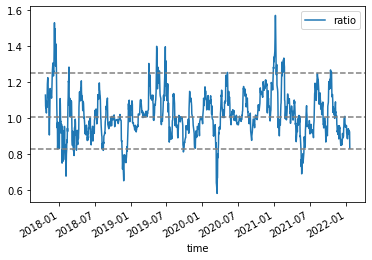

In [7]:
btc_usd_sma.visualizePercentiles()


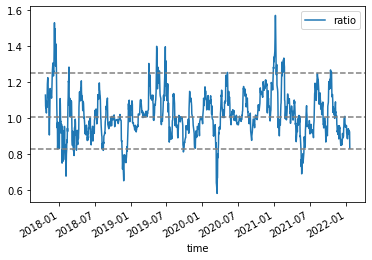

In [8]:
btc_usd_sma.visualizePercentiles()


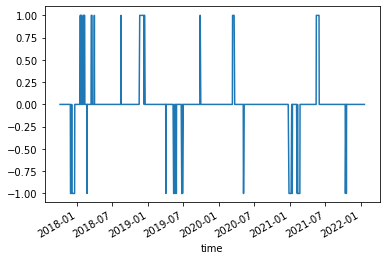

In [9]:
btc_usd_sma.visualizeSignals()


In [10]:
btc_usd_sma.data

,o,h,l,c,returns,ma,ratio,position,SMA_S,SMA_L
time,,,,,,,,,,
2017-10-03 21:00:00+00:00,4284.0,4341.7,4185.7,4199.6,NaN,NaN,NaN,0.0,NaN,NaN
2017-10-04 21:00:00+00:00,4199.6,4358.1,4144.5,4347.1,3.512239,NaN,NaN,0.0,NaN,NaN
2017-10-05 21:00:00+00:00,4347.1,4410.7,4299.7,4336.9,-0.234639,NaN,NaN,0.0,NaN,NaN
2017-10-06 21:00:00+00:00,4336.9,4367.8,4318.6,4336.3,-0.013835,NaN,NaN,0.0,NaN,NaN
2017-10-07 21:00:00+00:00,4336.3,4609.9,4336.2,4579.9,5.617693,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-01-16 22:00:00+00:00,43372.6,43575.8,41622.0,41737.8,-3.713034,45857.055,0.910172,0.0,45857.055,53802.65375
2022-01-17 22:00:00+00:00,41665.2,42499.9,41288.2,42390.4,1.563571,45521.630,0.931214,0.0,45521.630,53810.34625
2022-01-18 22:00:00+00:00,42298.0,42683.1,41147.8,41726.2,-1.566864,45154.800,0.924070,0.0,45154.800,53817.88750


In [11]:
btc_usd_sma.plotCandles()



In [17]:
import backtesting

/usr/local/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [103]:
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
import numpy as np
import pandas as pd

In [37]:
# Helper Functions

def SMA(arr, n) -> pd.Series:
    return pd.Series(arr).rolling(n).mean()

def RSI(array, n):
    gain = pd.Series(array).diff()
    loss = gain.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    rs = gain.ewm(n).mean() / loss.abs().ewm(n).mean()
    return 100 - 100 / (1 + rs)

def lower_band(sma, std, dev):
    return sma - std * dev

def upper_band(sma, std, dev):
    return sma + std * dev


In [38]:
class SMA_Strategy(Strategy):
    l1 = 5
    l2 = 25
    
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, self.l1)
        self.ma2 = self.I(SMA, price, self.l2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()
            
class Momentum_Strategy(Strategy):
    d_rsi = 14
    sell_level = 70
    level = 30
    
    
    def init(self):
       
        # Compute daily RSI(14)
        self.my_rsi = self.I(RSI, self.data.Close, self.d_rsi) 
        
    def next(self):
        price = self.data.Close[-1]
        
        if (self.my_rsi[-1] < self.level):        
            self.buy()
        
        elif self.my_rsi[-1] > self.sell_level:
            self.position.close()

In [39]:
btc_usd = InstrumentHandler("BTC_USD")

BTC_USD Initialized


In [41]:
bt = Backtest(btc_usd.get_backtest_dataset(), SMA_Strategy, commission=.002,
              exclusive_orders=True, cash=1000000)
stats = bt.run()
# bt.plot()

In [42]:
stats

Start                     2017-10-03 21:00...
End                       2022-01-20 22:00...
Duration                   1570 days 01:00:00
Exposure Time [%]                        96.5
Equity Final [$]                27473041.2458
Equity Peak [$]                 27518099.6458
Return [%]                        2647.304125
Buy & Hold Return [%]              771.968759
Return (Ann.) [%]                  173.947579
Volatility (Ann.) [%]              250.980222
Sharpe Ratio                         0.693073
Sortino Ratio                        3.492101
Calmar Ratio                         2.691439
Max. Drawdown [%]                  -64.629964
Avg. Drawdown [%]                   -9.638009
Max. Drawdown Duration      513 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                   45
Win Rate [%]                        46.666667
Best Trade [%]                      193.23978
Worst Trade [%]                    -20.386856
Avg. Trade [%]                    

In [43]:
stats = bt.optimize(l1=range(5, 30, 5),
                    l2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.l1 < param.l2)
stats

/usr/local/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


Start                     2017-10-03 21:00...
End                       2022-01-20 22:00...
Duration                   1570 days 01:00:00
Exposure Time [%]                        96.5
Equity Final [$]                27473041.2458
Equity Peak [$]                 27518099.6458
Return [%]                        2647.304125
Buy & Hold Return [%]              771.968759
Return (Ann.) [%]                  173.947579
Volatility (Ann.) [%]              250.980222
Sharpe Ratio                         0.693073
Sortino Ratio                        3.492101
Calmar Ratio                         2.691439
Max. Drawdown [%]                  -64.629964
Avg. Drawdown [%]                   -9.638009
Max. Drawdown Duration      513 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                   45
Win Rate [%]                        46.666667
Best Trade [%]                      193.23978
Worst Trade [%]                    -20.386856
Avg. Trade [%]                    

In [44]:
stats['_strategy']

<Strategy SMA_Strategy(l1=5,l2=25)>

In [48]:
btc_usd_momentum_bt = Backtest(btc_usd.get_backtest_dataset(), Momentum_Strategy, commission=.002,
              exclusive_orders=True, cash=1000000)
btc_usd_momentum_bt.run()

Start                     2017-10-03 21:00...
End                       2022-01-20 22:00...
Duration                   1570 days 01:00:00
Exposure Time [%]                   28.083333
Equity Final [$]                 1481458.5422
Equity Peak [$]                  1771252.9742
Return [%]                          48.145854
Buy & Hold Return [%]              771.968759
Return (Ann.) [%]                    12.69848
Volatility (Ann.) [%]               50.635552
Sharpe Ratio                         0.250782
Sortino Ratio                        0.467692
Calmar Ratio                         0.280262
Max. Drawdown [%]                  -45.309261
Avg. Drawdown [%]                  -11.913803
Max. Drawdown Duration      509 days 00:00:00
Avg. Drawdown Duration       62 days 00:00:00
# Trades                                   46
Win Rate [%]                        34.782609
Best Trade [%]                      67.109557
Worst Trade [%]                    -17.115123
Avg. Trade [%]                    

In [50]:
stats = btc_usd_momentum_bt.optimize(
            d_rsi = range(3, 27, 3),
            sell_level = range(60, 90, 5),
            level = range(5, 30, 5),
            maximize='Equity Final [$]',
            constraint=lambda param: param.level < param.sell_level)
stats

Start                     2017-10-03 21:00...
End                       2022-01-20 22:00...
Duration                   1570 days 01:00:00
Exposure Time [%]                   43.083333
Equity Final [$]                  5073221.488
Equity Peak [$]                   5073221.488
Return [%]                         407.322149
Buy & Hold Return [%]              771.968759
Return (Ann.) [%]                   63.879198
Volatility (Ann.) [%]               96.704039
Sharpe Ratio                         0.660564
Sortino Ratio                        1.832354
Calmar Ratio                         1.051854
Max. Drawdown [%]                  -60.730112
Avg. Drawdown [%]                  -10.935223
Max. Drawdown Duration      483 days 00:00:00
Avg. Drawdown Duration       53 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     408.282711
Worst Trade [%]                    408.282711
Avg. Trade [%]                    

In [51]:
eu50 = InstrumentHandler('EU50_EUR')

EU50_EUR Initialized


In [56]:
eu50_momentum_bt = Backtest(eu50.get_backtest_dataset(), Momentum_Strategy, commission=.002,
              exclusive_orders=True, cash=1000000)
eu50_momentum_bt.run()

Start                     2017-05-09 21:00...
End                       2022-01-20 22:00...
Duration                   1717 days 01:00:00
Exposure Time [%]                       54.25
Equity Final [$]                 1363739.4006
Equity Peak [$]                  1405116.3006
Return [%]                           36.37394
Buy & Hold Return [%]               14.649647
Return (Ann.) [%]                    9.895725
Volatility (Ann.) [%]               23.542864
Sharpe Ratio                         0.420328
Sortino Ratio                        0.618481
Calmar Ratio                         0.285808
Max. Drawdown [%]                  -34.623646
Avg. Drawdown [%]                     -3.0166
Max. Drawdown Duration      512 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   32
Win Rate [%]                             37.5
Best Trade [%]                      35.134356
Worst Trade [%]                    -12.213617
Avg. Trade [%]                    

In [58]:
stats = eu50_momentum_bt.optimize(
            d_rsi = range(3, 27, 3),
            sell_level = range(60, 90, 5),
            level = range(5, 30, 5),
            maximize='Equity Final [$]',
            constraint=lambda param: param.level < param.sell_level)
stats['_strategy']

/usr/local/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning:

For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.



<Strategy Momentum_Strategy(d_rsi=24,sell_level=65,level=25)>

In [101]:
class Mean_Reversion_Strategy(Strategy):
    SMA = 30
    dev = 2
   
    
    def init(self):
        self.std = SMA(self.data.Close, self.SMA).std()
       
        # Compute daily RSI(14)
        self.ma = self.I(SMA, self.data.Close, self.SMA) 
        self.lower = self.I(lower_band, self.ma, self.std, self.dev) 
        self.upper = self.I(upper_band, self.ma, self.std, self.dev) 

        
    def next(self):
        price = self.data.Close[-1]
        
        if crossover(self.data.Close, self.lower):
            self.buy()
        elif crossover(self.upper,self.data.Close ):
            self.sell()
            

In [102]:
eu50_mr_bt = Backtest(eu50.get_backtest_dataset(), Mean_Reversion_Strategy, commission=.002,
              exclusive_orders=True, cash=1000000)
eu50_mr_bt.run()

Start                     2017-05-09 21:00...
End                       2022-01-20 22:00...
Duration                   1717 days 01:00:00
Exposure Time [%]                       39.75
Equity Final [$]                 1418481.6928
Equity Peak [$]                  1471287.0928
Return [%]                          41.848169
Buy & Hold Return [%]               14.649647
Return (Ann.) [%]                   11.219188
Volatility (Ann.) [%]               22.078295
Sharpe Ratio                         0.508155
Sortino Ratio                        0.774891
Calmar Ratio                          0.54711
Max. Drawdown [%]                  -20.506271
Avg. Drawdown [%]                    -2.92025
Max. Drawdown Duration      156 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                    2
Win Rate [%]                             50.0
Best Trade [%]                      56.868798
Worst Trade [%]                     -9.569807
Avg. Trade [%]                    

In [85]:
eu50_mr_bt.plot()

<ipython-input-85-4cfd17b5d4b0>:1: UserWarning:

Superimposed OHLC plot matches the original plot. Skipping.



Row(id='2008', ...)

In [86]:
import decimal

def float_range(start, stop, step):
  while start < stop:
    yield float(start)
    start += decimal.Decimal(step)
float_range(0, 1, '0.1')

<generator object float_range at 0x11432e970>

In [98]:
stats = eu50_mr_bt.optimize(
            dev = [x * 0.1 for x in range(0, 30)],
            SMA = range(5, 30, 3),
            maximize='Equity Final [$]')

/usr/local/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning:

For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.



In [99]:
stats

Start                     2017-05-09 21:00...
End                       2022-01-20 22:00...
Duration                   1717 days 01:00:00
Exposure Time [%]                   39.083333
Equity Final [$]                  1783910.512
Equity Peak [$]                   1850312.512
Return [%]                          78.391051
Buy & Hold Return [%]               14.649647
Return (Ann.) [%]                   19.250252
Volatility (Ann.) [%]               19.402714
Sharpe Ratio                         0.992142
Sortino Ratio                        1.861305
Calmar Ratio                         1.464512
Max. Drawdown [%]                  -13.144481
Avg. Drawdown [%]                   -2.677657
Max. Drawdown Duration      156 days 00:00:00
Avg. Drawdown Duration       21 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      78.490146
Worst Trade [%]                     78.490146
Avg. Trade [%]                    

In [100]:
stats['_strategy']

<Strategy Mean_Reversion_Strategy(dev=2.3000000000000003,SMA=26)>